In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install csaps

In [3]:
!pip install ipython-autotime
%load_ext autotime

time: 192 µs (started: 2021-06-29 10:40:32 +00:00)


In [4]:
cd '/content/drive/MyDrive/BTL'

/content/drive/MyDrive/BTL
time: 13.2 ms (started: 2021-06-29 10:40:32 +00:00)


In [5]:
import numpy as np
import scipy.ndimage.filters
import cv2
from csaps import csaps
import scipy.signal as sig
import os
import scipy.signal as signal
from scipy import ndimage
import sys
import matplotlib.pyplot as plt
import glob

time: 1.28 s (started: 2021-06-29 10:40:32 +00:00)


In [6]:
def orientated_non_max_suppression(mag, ang):
    ang_quant = np.round(ang / (np.pi/4)) % 4
    winE = np.array([[0, 0, 0],
                     [1, 1, 1],
                     [0, 0, 0]])
    winSE = np.array([[1, 0, 0],
                      [0, 1, 0],
                      [0, 0, 1]])
    winS = np.array([[0, 1, 0],
                     [0, 1, 0],
                     [0, 1, 0]])
    winSW = np.array([[0, 0, 1],
                      [0, 1, 0],
                      [1, 0, 0]])

    magE = non_max_suppression(mag, winE)
    magSE = non_max_suppression(mag, winSE)
    magS = non_max_suppression(mag, winS)
    magSW = non_max_suppression(mag, winSW)

    mag[ang_quant == 0] = magE[ang_quant == 0]
    mag[ang_quant == 1] = magSE[ang_quant == 1]
    mag[ang_quant == 2] = magS[ang_quant == 2]
    mag[ang_quant == 3] = magSW[ang_quant == 3]
    return mag

def non_max_suppression(data, win):
    data_max = scipy.ndimage.filters.maximum_filter(data, footprint=win, mode='constant')
    data_max[data != data_max] = 0
    return data_max

def edge(gray_image):
# compute sobel response
    sobelx = cv2.Sobel(gray_image, cv2.CV_32F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray_image, cv2.CV_32F, 0, 1, ksize=3)
    mag = np.hypot(sobelx, sobely)
    ang = np.arctan2(sobely, sobelx)
    # threshold
    fudgefactor = 0.5
    threshold = 4 * fudgefactor * np.mean(mag)
    mag[mag < threshold] = 0
    # non-maximal suppression
    mag = orientated_non_max_suppression(mag, ang)
    # alternative but doesn't consider gradient direction
    # mag = skimage.morphology.thin(mag.astype(np.bool)).astype(np.float32)

    # create mask
    mag[mag > 0] = 255
    mag = mag.astype(np.uint8)
    return mag

def remove_small_cc(img,size):
    bin_img = cv2.threshold(img,127,1,cv2.THRESH_BINARY)[1]
    cc2_bin_img = cv2.connectedComponentsWithStats(bin_img)
    for cc in range(cc2_bin_img[0]):
        ind_cc = cc2_bin_img[2][cc]
        if ind_cc[cv2.CC_STAT_AREA] < size:
            x = ind_cc[cv2.CC_STAT_LEFT]
            y = ind_cc[cv2.CC_STAT_TOP]
            w = ind_cc[cv2.CC_STAT_WIDTH]
            h = ind_cc[cv2.CC_STAT_HEIGHT]
            img[y:y+h, x:x+w] = 0
    return img

def projection_profile(img, s, dim=0, smooth=0.000001):
    """
    Projection profile by given dimension of image.
    @args
    img: input image
    s: number of slices 
    dim =0 horizontal
    dim =1 vertical
    """
    r, c = img.shape[:2]
    w = int(np.floor(c/s))
    ## compute horizontal projection profiles of all edge image slices 
    ## and find their local maxima
    local_max  = []   # locations of local maxima
    list_distances  = []   # locations of local maxima

    k = 0  # help counter for the slices
    list_of_proj_smooth = []  # help counter for the slices
    for i in range(s):
        # for each slice
        # computes histogram of sum of edges
        if dim == 0:
            proj = np.sum(img[:,k:k+w-1],1)
        proj_smooth = csaps([i for i in range(r)],proj,[i for i in range(r)],smooth=smooth)
        list_of_proj_smooth.append(proj_smooth)

        # find peaks of the profile
        peaks, _ =  sig.find_peaks(proj_smooth)

        tmp_distances = []       
        for cnt in range(len(peaks)-1):
            tmp_distances.append(peaks[cnt+1]-peaks[cnt])
        # Append candiate
        local_max.append(peaks)
        list_distances.append(np.mean(tmp_distances))
        # Move next slice
        k = k + w
    return local_max

def draw_projection(img,list_of_proj_smooth,local_max,list_distances):
    """
    draw local projection profile
    """
    r,c = img.shape
    mask = np.stack([img] * 3, axis=2)

    #fig, (ax1, ax2, ax3) = plt.subplots(1,3)
    #for i in range(len)
    n_slices = len(list_distances)
    space = int(c/n_slices)
    list_color = [(10,255,255),(255,255,10),(255,10,255)]
    new_peaks = []
    for i in range(n_slices):
        #fig, (ax1, ax2, ax3) = plt.subplots(1,1)

        #ax1.plot(list_of_proj_smooth[i],row_number)
        #ax2.plot(list_of_proj_smooth[1],row_number)
        #ax3.plot(list_of_proj_smooth[2],row_number)
        tmp = []
        for j in range(len(local_max[i])):
            if list_of_proj_smooth[i][local_max[i][j]] <200:
                continue
            tmp.append(local_max[i][j])
            cv2.line(mask,pt1=(i*space,int(local_max[i][j])),pt2=((i+1)*space,int(local_max[i][j])),color=list_color[i%3],thickness=5)    
        new_peaks.append(tmp)
    #print(local_max,new_peaks)
    #for i in range(len(local_max[1])):
        #cv2.line(mask,pt1=(int(c/3),int(local_max[1][i])),pt2=(int(2*c/3),int(local_max[1][i])),color=(255,255,10),thickness=5)
    #for i in range(len(local_max[2])):
    #    cv2.line(mask,pt1=(int(2*c/3),int(local_max[2][i])),pt2=(c,int(local_max[2][i])),color=(255,10,255),thickness=5)  
    
    cv2.imwrite('localpp_new.png',mask)

    return new_peaks

def draw_separating_line(mask, sep_seam, L, idx):
    L_lower = L[idx][0][0]
    L_upper = L[idx][1][0]
    r,c, _ = mask.shape
    cv2.line(mask,pt1=(0,L_lower),pt2=(c,L_lower),color=(10,255,255),thickness=10)
    cv2.line(mask,pt1=(0,L_upper),pt2=(c,L_upper),color=(10,255,255),thickness=10)
    list_point = []
    for i in range(c):
        list_point.append([i,int(sep_seam[i][0])])
    list_point = np.array(list_point)
    cv2.polylines(mask, [list_point], False, (255,100,255), 5)
    return mask

def compute_separate_seam_carving(img, L,idx):
    
    # Compute energy map 
    sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=11)
    sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=11)
    energy_map = abs(sobelx) + abs(sobely)

    # transpose the energy map, because we compute vertical seams
    energy_map = energy_map.T

    line_lower  = L[idx][0]
    line_upper = L[idx][1]
    # initialize seam coordinates
    sep_seams = np.zeros((len(line_lower),1))

    # copy the energy map for the dynamic programming part 
    new_energy = energy_map

    ## apply constrained seam carving for each pair of text lines

    # upper and lower medial seams
    L_a = line_lower
    L_b = line_upper

    # length of the medial seam (maybe they do not extend
    # through the whole page width)
    l_a = len(L_a)
    l_b = len(L_b)
    min_l = min(l_a,l_b)   # minimum of the two text line lengths
    ## compute minimum energy separating seam using dynamic programming
    for row in range(1,min_l):
        for col in range(L_a[row],L_b[row]+1):
            # find previous row's neighbors for the cumulative matrix
            # computation and take care not to overstep the boundaries of 
            # the image
            left = max(col-2,L_a[row-1])
            right = min(col+2,L_b[row-1])
            # find the minimum value of the previous row's neighbors
            #minpath = min(new_energy[row-1,left:right+1])

            # take care of discontinuous boundaries in the text line 
            # approximations
            if new_energy[row-1,left:right+1] is None:  # we are in the boundary 
                # many pixels difference, discontinuity
                if (col > left):     
                    new_energy[row,col] = 2 * new_energy[row-1,right]
                elif (col < right):   
                    new_energy[row,col] =  2 * new_energy[row-1,left]
                else:
                    # todo something
                    pass
            else:    # one pixel difference, no discontinuity
                new_energy[row,col] = 2* energy_map[row,col] + min(new_energy[row-1,left:right+1])
    ## trace the path backwards
    # find the minimum energy path at the bottom, the index of 
    # the minimum energy is the starting point
    min_index = np.argmin(new_energy[min_l-1,L_a[min_l-1]:L_b[min_l-1]+1])
    min_index = L_a[min_l-1] + min_index # correct index in the entire image
    # backtrack through the energy map from bottom to top  
    # to determine the minimum energy seam
    for row in reversed(range(min_l)):
        # the column of the minimum energy seam
        j = min_index

        # update the seam map
        sep_seams[row,0]= j
        # find next row's neighbors
        left = max(j-2,L_a[row-1])
        right = min(j+2,L_b[row-1])

        # the column of the minimum energy seam
        min_index = np.argmin(new_energy[row-1,left:right+1])


        min_index = min_index + left   
    sep_seams[0,0] = min_index + np.argmin(new_energy[0,min_index-1:min_index+2])
    # reset the energy values
    new_energy = energy_map 
    return sep_seams

def main(path_img, n_slides, smooth=0.000001, size=(10, 10)):

    """
    @args input path_img: input to the path image
                s: number of slide by width image
    """
    # Read image
    img = cv2.imread(path_img,0)

    # Find edge image
    edges_img = edge(img)
    # binary image that will contains the piece-wise text line approximations
    img_bin = np.zeros_like(img)

    r, c = img.shape
    s = int(n_slides)

    # compute width of each slice
    w = int(np.floor(c/s))

    local_max = projection_profile(edges_img, s, smooth=smooth)
    
    # Half of slice width
    k = int(np.floor(w/2))

    medial_seams_inds = []

    for i in range(s-1):

        # if there is not exist local maxima, skip
        if len(local_max[i]) == 0:
            continue
        len_local_max_i = len(local_max[i])
        len_local_max_i_1 = len(local_max[i+1])

        matches_lr = np.zeros((len_local_max_i,1))
        matches_rl = np.zeros((len_local_max_i_1,1))
        for j in range(len_local_max_i):
            dists = [ abs(local_max[i][j]-x) for x in local_max[i+1]]

            matches_lr[j] = dists.index(min(dists))
            

        for j in range(len_local_max_i_1):

            dists = [ abs(local_max[i+1][j]-x) for x in local_max[i]]

            matches_rl[j] = dists.index(min(dists))
            

        # validate the corresponding similar peak
        for j in range(len_local_max_i):
            for o in range(len_local_max_i_1):
                if (matches_lr[j] ==o) and (matches_rl[o]==j):

                    if i==0:
                        points = np.round(np.linspace(local_max[i][j],local_max[i+1][o],k))
                        points =[int(x) for x in points]
                        img_bin[points,np.arange(0,k)] = 255
                        
                        #list_idx = np.ravel_multi_index([np.arange(0,k),points],(c,r))
                        #medial_seams_inds.append(list_idx)

                    elif i==s-2:
                        ran = np.arange(k,c)
                        # rounded row coordinates for the last pair of slices
                        points = np.round(np.linspace(local_max[i][j],local_max[i+1][o],len(ran)))
                        points =[int(x) for x in points]

                        # linear indices on the entire image
                        #tmp = np.array([ran,points])
                        #inds = np.ravel_multi_index(tmp,(c,r))
                        img_bin[points,ran] = 255
                        #medial_seams_inds.append(list_idx)
                    else:
                        # rounded row coordinates for an intermediate pair of
                        # slices
                        points = np.round(np.linspace(local_max[i][j],local_max[i+1][o],w))
                        points =[int(x) for x in points]

                        # linear indices on the entire image

                        #list_idx = np.ravel_multi_index((np.arange(k,k+w),points),(c,r))
                        img_bin[points,np.arange(k,k+w)] =255
                        #medial_seams_inds.append(list_idx)

        if i > 0 and i < s-1:
            k = k + w

    img_bin = img_bin.astype(np.uint8)
    cc_img_bin = cv2.connectedComponentsWithStats(img_bin)
    num_cc = cc_img_bin[0]

    # remove incorrect component
    for cc in range(num_cc):
        ind_cc = cc_img_bin[2][cc]
        x = ind_cc[cv2.CC_STAT_LEFT]
        y = ind_cc[cv2.CC_STAT_TOP]
        w = ind_cc[cv2.CC_STAT_WIDTH]
        h = ind_cc[cv2.CC_STAT_HEIGHT]
        if x != 0 or w!=c:
            img_bin[y:y+h, x:x+w] = 0

    # connected component analysis of the final binary image containing 
    # the medial seams
    cc2_bin_img = cv2.connectedComponentsWithStats(img_bin)
    num_cc = cc2_bin_img[0]

    # smooth the piece-wise medial seams with a spline 
    # and save them 
    L = {}
    # for each connected component
    for cc in range(1,num_cc-1):   
        inds_cc = cc2_bin_img[2][cc]
        inds_cc1 = cc2_bin_img[2][cc+1]

        # discard small components, here threshold!!!!!
        if (ind_cc[cv2.CC_STAT_AREA] < 10):   
            continue;
        y = inds_cc[cv2.CC_STAT_TOP]
        h = inds_cc[cv2.CC_STAT_HEIGHT]
        y1 = inds_cc1[cv2.CC_STAT_TOP]
        h1 = inds_cc1[cv2.CC_STAT_HEIGHT]    
        # calculate (x,y) coordinates of connected component
        #[I,J] = np.unravel_index(img_bin[y:y+h,x:x+w],[r,c]);
        # smooth the component with a spline
        #sp = spaps(J,I,0.1);
        # evaluate the spline and round the output
        #f = scipy.interpolate.interp2d(np.arange(x,x+w),np.arange(y,y+h),img_bin[y:y+h,x:x+w])

        #[I,J] = np.unravel_index(img_bin[y:y+h,x:x+w],[r,c])
        #spaps = SmoothBSpline()
        #w = np.zeros_like(I)
        #sp = spaps.bspl(I,J,w,0.1)

        #print(I.shape,J.shape)
        #assert(1==2)
        points_lower = c * [y+h] 
        points_upper = c * [y1+h1] 

        L[cc] =[points_lower,points_upper]



    mask = np.stack([img] * 3, axis=2)
    for lp in range(len(L)):
        sep_seams = compute_separate_seam_carving(img, L, lp+1)
        if lp == 0:
            drawed_img = draw_separating_line(mask, sep_seams, L, lp+1)
        else:
            drawed_img = draw_separating_line(drawed_img, sep_seams, L, lp+1)

    plt.figure(figsize = size)
    plt.imshow(drawed_img)
    plt.show()
    # output_name = 'line_separation_'+ os.path.basename(path_img)

    # cv2.imwrite(output_name,drawed_img)
    # cv2.imshow(output_name,drawed_img)
    # cv2.waitKey(0)

time: 1.57 s (started: 2021-06-29 10:40:38 +00:00)


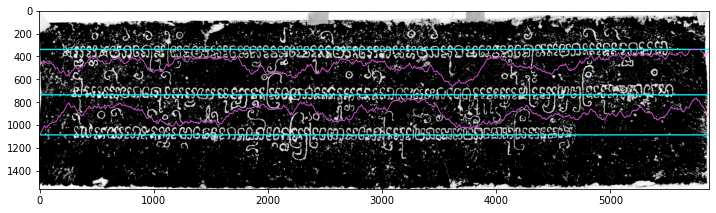

time: 40.9 s (started: 2021-06-29 10:40:39 +00:00)


In [7]:
main('images/C 3 A1.png',3, 1e-6, size=(12, 12))

Đường phân chia đúng: 2

Đường loại I: 0 \\
Đường loại II: 2 \\
Đường loại III: 0 \\
Đường loại IV: 0 \\
Tổng: 2

Precision = 2/2 = 100% \\
Recall: 2/2 = 100%

In [8]:
file_names = glob.glob('images/*.png')

time: 5.77 ms (started: 2021-06-29 10:41:20 +00:00)


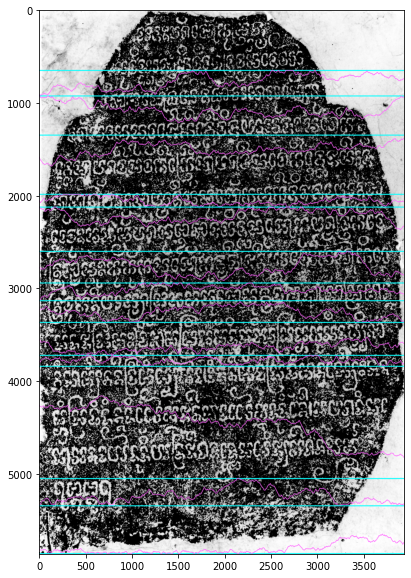

time: 3min 12s (started: 2021-06-26 11:01:19 +00:00)


In [ ]:
main(file_names[0], 3, 2e-6)

Đường phân chia đúng: 13

Đường loại I: 0 \\
Đường loại II: 6 \\
Đường loại III: 0 \\
Đường loại IV: 6 \\
Tổng: 12

Precision = 6/12 = 50% \\
Recall: 6/13 = 46.15%

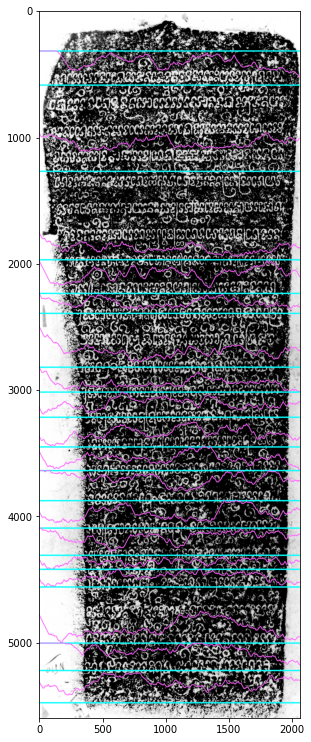

time: 1min 48s (started: 2021-06-26 11:04:47 +00:00)


In [ ]:
main(file_names[1], 3, 5e-6, size=(13, 13))

Đường phân chia đúng: 22

Đường loại I: 0 \\
Đường loại II: 9 \\
Đường loại III: 6 \\
Đường loại IV: 3 \\
Tổng: 18

Precision = 9/18 = 50% \\
Recall: 9/22 = 40.91%

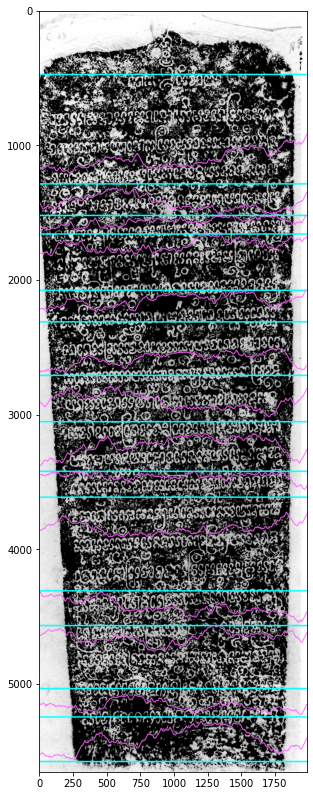

time: 1min 37s (started: 2021-06-26 11:06:36 +00:00)


In [ ]:
main(file_names[2], 3, 2e-6, size=(14, 14))

Đường phân chia đúng: 22

Đường loại I: 0 \\
Đường loại II: 8 \\
Đường loại III: 1 \\
Đường loại IV: 5 \\
Tổng: 13

Precision = 8/13 = 61.54% \\
Recall: 8/22 = 36.36%

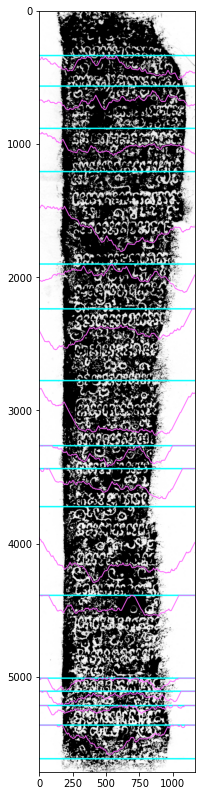

time: 59.4 s (started: 2021-06-26 11:08:13 +00:00)


In [ ]:
main(file_names[3], 3, 4e-6, size=(14, 14))

Đường phân chia đúng: 22

Đường loại I: 0 \\
Đường loại II: 8 \\
Đường loại III: 1 \\
Đường loại IV: 5 \\
Tổng: 14

Precision = 8/14 = 57.14% \\
Recall: 8/22 = 36.36%

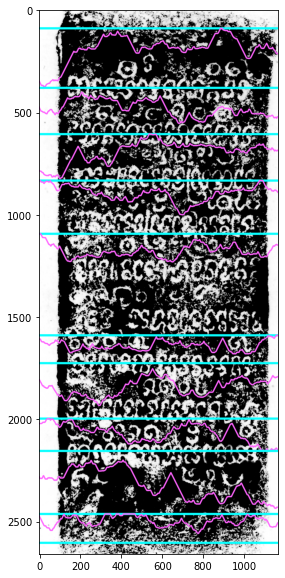

time: 27.4 s (started: 2021-06-26 11:09:12 +00:00)


In [ ]:
main(file_names[4], 3, 8e-6)

Đường phân chia đúng: 8

Đường loại I: 0 \\
Đường loại II: 6 \\
Đường loại III: 1 \\
Đường loại IV: 3 \\
Tổng: 10

Precision = 6/10 = 60% \\
Recall: 6/8 = 75%

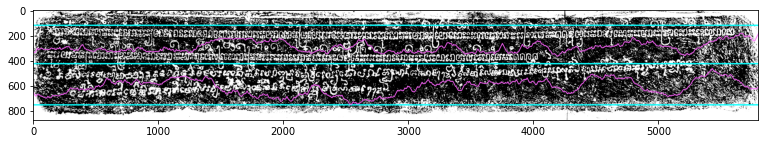

time: 32 s (started: 2021-06-26 11:09:40 +00:00)


In [ ]:
main(file_names[5], 3, 1e-6, size=(13, 13))

Đường phân chia đúng: 3

Đường loại I: 0 \\
Đường loại II: 1 \\
Đường loại III: 0 \\
Đường loại IV: 1 \\
Tổng: 2

Precision = 1/2 = 50% \\
Recall: 1/3 = 33.33%

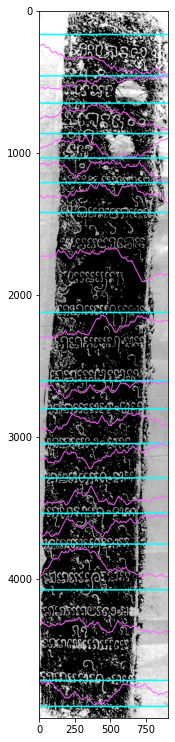

time: 41.8 s (started: 2021-06-26 11:10:12 +00:00)


In [ ]:
main(file_names[6], 3, 5e-6, size=(13, 13))

Đường phân chia đúng: 19

Đường loại I: 6 \\
Đường loại II: 8 \\
Đường loại III: 1 \\
Đường loại IV: 1 \\
Tổng: 16

Precision = 14/16 = 87.5% \\
Recall: 14/19 = 73.68%

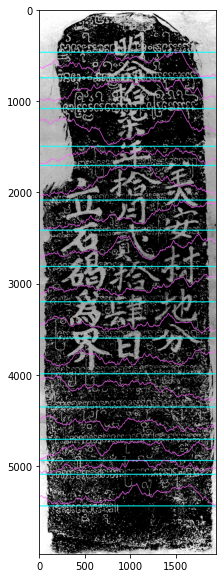

time: 1min 33s (started: 2021-06-26 11:10:54 +00:00)


In [ ]:
main(file_names[7], 3, 1e-6)

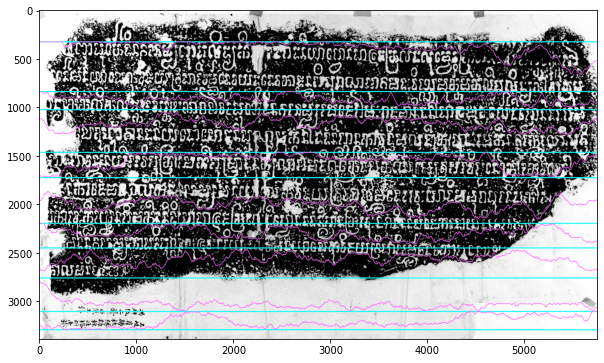

time: 2min 35s (started: 2021-06-26 11:12:27 +00:00)


In [ ]:
main(file_names[8], 3, 3e-6)

Đường phân chia đúng: 8

Đường loại I: 0 \\
Đường loại II: 5 \\
Đường loại III: 0 \\
Đường loại IV: 4 \\
Tổng: 9

Precision = 5/9 = 55.56% \\
Recall: 5/8 = 62.5%

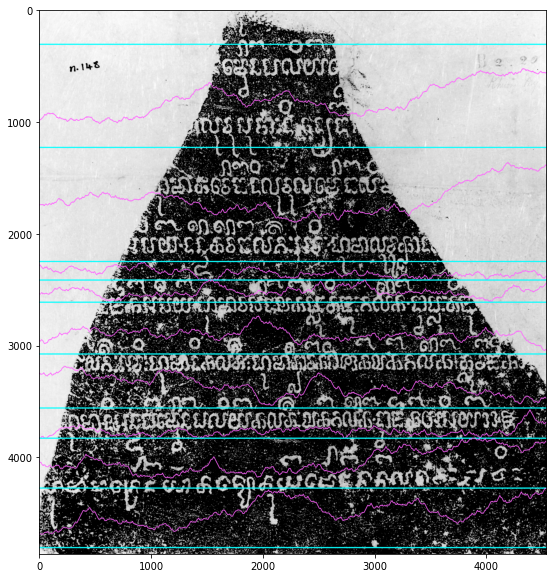

time: 3min 4s (started: 2021-06-26 11:15:03 +00:00)


In [ ]:
main(file_names[9], 3, 2e-6)

Đường phân chia đúng: 7

Đường loại I: 1 \\
Đường loại II: 5 \\
Đường loại III: 0 \\
Đường loại IV: 3 \\
Tổng: 9

Precision = 6/9 = 66.67% \\
Recall: 6/7 = 85.71%

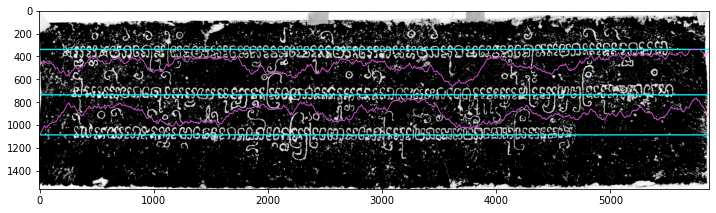

time: 38.7 s (started: 2021-06-26 11:18:07 +00:00)


In [ ]:
main(file_names[10], 3, 1e-6, size=(12, 12))

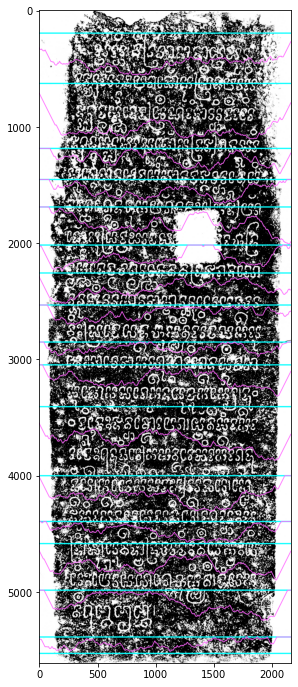

time: 1min 50s (started: 2021-06-26 11:18:46 +00:00)


In [ ]:
main(file_names[11], 3, 1e-6, (12, 12))

Đường phân chia đúng: 18

Đường loại I: 0 \\
Đường loại II: 15 \\
Đường loại III: 0 \\
Đường loại IV: 1 \\
Tổng: 16

Precision = 15/16 = 93.75% \\
Recall: 15/18 = 83.33%

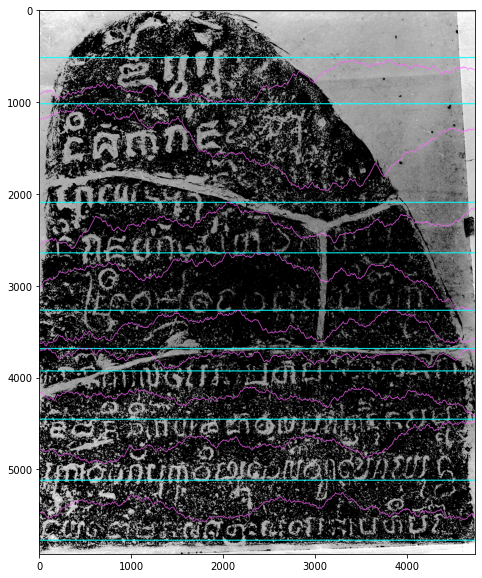

time: 3min 44s (started: 2021-06-26 11:20:37 +00:00)


In [ ]:
main(file_names[12], 3, 5e-7)

Đường phân chia đúng: 8

Đường loại I: 2 \\
Đường loại II: 5 \\
Đường loại III: 0 \\
Đường loại IV: 1 \\
Tổng: 8

Precision = 7/8 = 87.5% \\
Recall: 7/8 = 87.5%

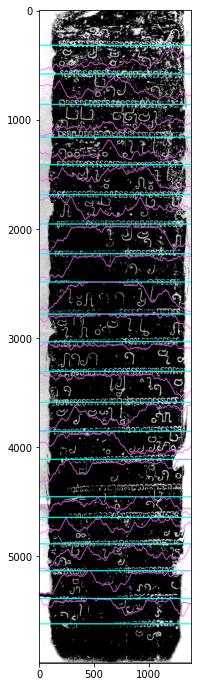

time: 1min 14s (started: 2021-06-26 11:24:21 +00:00)


In [ ]:
main(file_names[13], 3, 1e-6, (12, 12))

Đường phân chia đúng: 20

Đường loại I: 3 \\
Đường loại II: 16 \\
Đường loại III: 1 \\
Đường loại IV: 0 \\
Tổng: 20

Precision = 19/20 = 95% \\
Recall: 19/20 = 95%

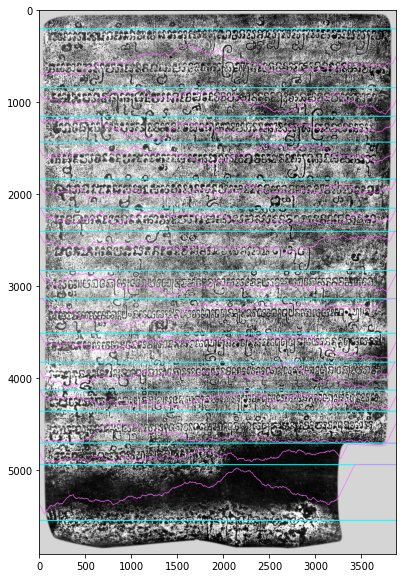

time: 3min 19s (started: 2021-06-26 11:25:36 +00:00)


In [ ]:
main(file_names[14], 3, 1e-6)

Đường phân chia đúng: 15

Đường loại I: 1 \\
Đường loại II: 0 \\
Đường loại III: 0 \\
Đường loại IV: 14 \\
Tổng: 15

Precision = 1/15 = 6.67% \\
Recall = 1/15 = 6.67%

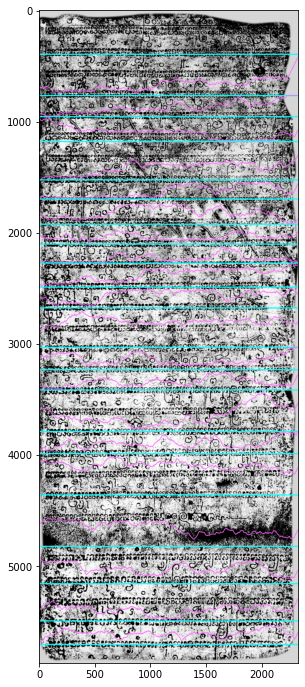

time: 2min 5s (started: 2021-06-26 11:28:55 +00:00)


In [ ]:
main(file_names[15], 3, 1e-6, (12, 12))

Đường phân chia đúng: 28

Đường loại I: 0 \\
Đường loại II: 17 \\
Đường loại III: 1 \\
Đường loại IV: 2 \\
Tổng: 20

Precision = 17/20 = 85% \\
Recall = 17/28 = 60.71%

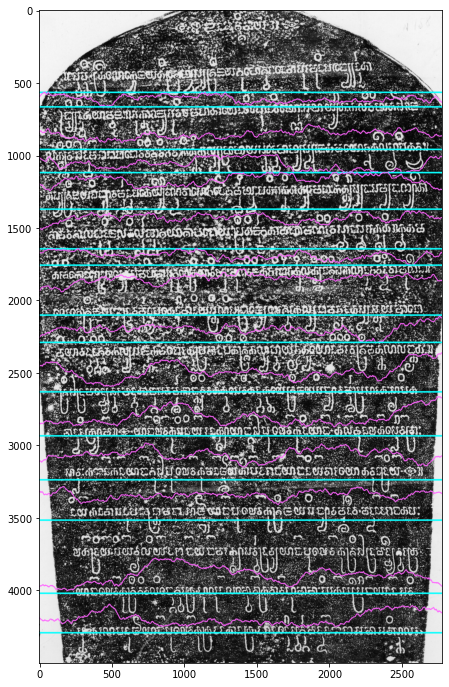

time: 1min 43s (started: 2021-06-29 11:01:34 +00:00)


In [12]:
main(file_names[19], 3, 3e-6, (12, 12))

Đường phân chia đúng: 15

Đường loại I: 0 \\
Đường loại II: 10 \\
Đường loại III: 1 \\
Đường loại IV: 1 \\
Tổng: 12

Precision = 10/12 = 83.33% \\
Recall = 10/15 = 66.67%